In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import pandas as pd

In [2]:
r_layer = np.array(
    [
        0.0431818181818182,
        17.7692400386911,
        0.09
    ]
)

c_layer = np.array(
    [
        7.885,
        7.10769601547645,
        0.0
    ]
) * 1000.0

# c_layer = np.array([
#     10375.0,
#     0.0,
#     10375.0,
#     0.0
# ])

# r_layer = np.array([
#     0.0568,
#     0.09,
#     0.0568,
#     0.120289612356129
# ])

In [3]:
# 伝達関数の計算
def calc_transfer_function(C_i_k_p: np.ndarray, R_i_k_p: np.ndarray, laps: float) -> (float, float):

    """

    Args:
        C_i_k_p: 層の熱容量[J/m2K]
        R_i_k_p: 層の熱抵抗[m2K/W]
        laps: ラプラス変数[1/s]

    Returns:
        貫流伝達関数[K]
        吸熱伝達関数[K]
    """

    # 四端子行列の初期化
    matFt = np.identity(2, dtype=float)

    for lngK, (R_k, C_k) in enumerate(zip(R_i_k_p, C_i_k_p)):

        # ---- 四端子基本行列 matFi ----
        if abs(C_k) < 0.001:
            # 定常部位（空気層等）の場合
            matFi = np.array([
                [1.0, R_k],
                [0.0, 1.0]
            ])
        else:
            # 非定常部位の場合
            dblTemp = np.sqrt(R_k * C_k * laps)
            dblCosh = np.cosh(dblTemp)
            dblSinh = np.sinh(dblTemp)

            matFi = np.array([
                [dblCosh, R_k / dblTemp * dblSinh],
                [dblTemp / R_k * dblSinh, dblCosh]
            ])

        # print('[Fi(', lngK, ')]')
        # print(matFi)

        # ---- 四端子行列 matFt ----
        matFt = np.dot(matFt, matFi)

    # print('martFt')
    # print(matFt)

    # 吸熱、貫流の各伝達関数ベクトルの作成
    GA = matFt[0, 1] / matFt[1, 1]
    GT = 1.0 / matFt[1][1]

    return (GA, GT)

In [4]:
def choice_alpha(t0: float, GT: np.ndarray, alpha_m_temp: np.ndarray) -> np.ndarray:

    nroot = len(alpha_m_temp)
    GT2 = np.zeros(nroot + 2, dtype=float)
    # 配列0に定常の伝達関数を入力
    GT2[0] = 1.0
    # 配列の最後にs=∞の伝達関数を入力
    GT2[nroot - 1] = 0.0
    # それ以外に計算した伝達関数を代入
    for i in range(nroot):
        GT2[i + 1] = GT[i]

    # 採用する固定根の場合1
    is_adopts = np.zeros(nroot, dtype=int)
    i = 0
    while i <= nroot + 1:
        for j in range(i + 1, nroot + 1):
            # 伝達関数が3%以上変化した根だけ採用する
            if math.fabs(GT2[j] - GT2[i]) > (t0 - GT[len(GT) - 1]) * 0.03:
                is_adopts[j - 1] = 1
                i = j - 1
                break
        i += 1

    # 不採用の固定根を削除
    for i, adopts in enumerate(reversed(is_adopts)):
        if adopts == 0:
            alpha_m_temp = np.delete(alpha_m_temp, nroot - i - 1)
    
    return alpha_m_temp

In [5]:
# ラプラス変数の設定
def get_laps(alp: np.ndarray) -> np.ndarray:
    """
    :param alp: 固定根
    :return: ラプラス変数の配列
    """
    n = len(alp) * 2  # 与えるラプラス変数の個数
    laps = [None] * n  # ラプラス変数の配列

    for i in range(1, n + 1):
        if i % 2 == 0:
            # 偶数番目はαをそのまま入力
            laps[i - 1] = alp[int((i - 1) / 2)]
        elif i == 1:
            # 最初はα1/√(α2/α1）とする
            laps[i - 1] = alp[0] / math.sqrt(alp[1] / alp[0])
        else:
            # それ以外は等比数列で補間
            lngL = math.ceil((i - 1) / 2)
            laps[i - 1] = alp[lngL] / math.sqrt(alp[lngL] / alp[lngL - 1])

    return np.array(laps)

In [6]:
# 貫流単位応答の下限値と上限値を保証する制約関数
def phi_t(x, t, t0, alpha_m_temp):
    phi = np.zeros(len(t))
    for i, ti in enumerate(t):
        phi[i] = t0 + np.sum(x * np.exp(-alpha_m_temp * ti * 900))

    return phi

In [7]:
# 吸熱単位応答の下限値と上限値を保証する制約関数
def phi_a(x, t, a0, alpha_m_temp):
    phi = np.zeros(len(t))
    for i, ti in enumerate(t):
        phi[i] = a0 + np.sum(x * np.exp(-alpha_m_temp * ti * 900))
    
    return phi

In [8]:
# x1 + x2 + x3 + x4 ・・・ + Y =0 制約
# 貫流応答用
def sum_constraint_t(x, t0):
    return t0 * 0.05 - abs(np.sum(x) + t0)

# 吸熱応答用
def sum_constraint_a(x, a0):
    return a0 * 0.05 - abs(np.sum(x) + a0)

In [9]:
# tに対する単位応答の微分が0以上であることを保証する制約関数
def diff_phi(x, t, alpha_m_temp):
    diff = np.zeros_like(t)
    for i, ti in enumerate(t):
        diff[i] = np.sum(-alpha_m_temp * x * np.exp(-alpha_m_temp * ti * 900))
    
    return diff

In [10]:
def make_mat_f(laps, alpha_m_temp) -> np.ndarray:

    # 伝達関数の係数を求めるための左辺行列を作成
    mat_f = np.zeros((len(laps), len(alpha_m_temp)))
    for i, lap in enumerate(laps):
        for j, root in enumerate(alpha_m_temp):
            mat_f[i, j] = lap / (lap + root)
    
    return mat_f

In [11]:
def make_mat_gt_ga(laps, t0, a0) -> (np.ndarray, np.ndarray):

    # 定数行列の作成
    mat_gt = np.zeros(len(laps))
    mat_ga = np.zeros(len(laps))

    for i, lap in enumerate(laps):

        # 伝達関数の計算
        (ga_value, gt_value) = calc_transfer_function(C_i_k_p=c_layer, R_i_k_p=r_layer, laps=lap)

        mat_gt[i] = gt_value - t0
        mat_ga[i] = ga_value - a0

    return (mat_gt, mat_ga)

In [12]:
def calc_error_t(x, mat_gt, mat_f):

    error = np.sum((mat_gt - np.sum(mat_f * x, axis=1)) ** 2, axis=0)
    # print(error)
    return error

def calc_error_a(x, mat_ga, mat_f):
    
    error = np.sum((mat_ga - np.sum(mat_f * x, axis=1)) ** 2, axis=0)
    # print(error)
    return error

In [13]:
def calc_response_factor(c_layer: np.ndarray, r_layer: np.ndarray):

    t0 = 1.0
    a0 = np.sum(r_layer)
    alpha_m = np.logspace(np.log10(1.0 / (86400.0 * 365.0)), np.log10(1.0 / 900.0), 10)
    alpha_m_temp = alpha_m

    # 実際に応答係数計算に使用する固定根を選定する
    GA = np.zeros_like(alpha_m_temp, dtype=float)
    GT = np.zeros_like(alpha_m_temp, dtype=float)

    # 固定根をラプラスパラメータとして伝達関数を計算
    for i, lap in enumerate(alpha_m_temp):
        (GA[i], GT[i]) = calc_transfer_function(C_i_k_p=c_layer, R_i_k_p=r_layer, laps=lap)
    
    # 応答係数計算に使用する固定根を選択
    alpha_m_temp = choice_alpha(t0=t0, GT=GT, alpha_m_temp=alpha_m_temp)

    # ラプラス変数の設定
    laps = get_laps(alpha_m_temp)

    # 単位応答の上下限、単調増加を担保するtの範囲を離散的な点に分割
    t_values = np.linspace(0, 2000, num=2000)

    # 制約の追加
    cons_t = [
            {
                'type': 'ineq',
                'fun': lambda x: sum_constraint_t(x=x, t0=t0)
            },
            {
                'type': 'ineq',
                'fun': lambda x, t=t_values, t0=t0, alpha_m_temp=alpha_m_temp: phi_t(x, t, t0, alpha_m_temp) - 0  # g(x, s) >= 0
            },
            {
                'type': 'ineq',
                'fun': lambda x, t=t_values, t0=t0, alpha_m_temp=alpha_m_temp : t0 - phi_t(x, t, t0, alpha_m_temp)  # g(x, s) <= 1
            },
            {
                'type': 'ineq',
                'fun': lambda x, t=t_values, alpha_m_temp=alpha_m_temp: diff_phi(x, t, alpha_m_temp) - 0  # dg(x, s) >= 0
            }
        ]

    cons_a = [
            {
                'type': 'ineq',
                'fun': lambda x: sum_constraint_a(x=x, a0=a0)
            },
            {
                'type': 'ineq',
                'fun': lambda x, t=t_values, a0=a0, alpha_m_temp=alpha_m_temp: phi_a(x, t, a0, alpha_m_temp) - 0  # g(x, s) >= 0
            },
            {
                'type': 'ineq',
                'fun': lambda x, t=t_values, a0=a0, alpha_m_temp=alpha_m_temp: a0 - phi_a(x, t, a0, alpha_m_temp)  # g(x, s) <= b0
            },
            {
                'type': 'ineq',
                'fun': lambda x, t=t_values, alpha_m_temp=alpha_m_temp: diff_phi(x, t, alpha_m_temp) - 0  # dg(x, s) >= 0
            }
        ]
    
    mat_f = make_mat_f(laps=laps, alpha_m_temp=alpha_m_temp)
    (mat_gt, mat_ga) = make_mat_gt_ga(laps=laps, t0=t0, a0=a0)

    # 最適化の実行

    # 初期値
    xt0 = np.full(len(alpha_m_temp), -t0 / len(alpha_m_temp), float)

    result_t = minimize(lambda x, mat_gt=mat_gt, mat_f=mat_f: calc_error_t(x, mat_gt, mat_f), xt0, method='COBYLA', constraints=cons_t, tol=1.0e-8, options={'maxiter': 10000, 'disp': True})

    print(result_t)

    # グラフ描画
    phi_t_value = phi_t(x=result_t.x, t=t_values, t0=t0, alpha_m_temp=alpha_m_temp)
    df_t = pd.DataFrame(columns=['x', 'phi_t'])
    df_t['x'] = t_values
    df_t['phi_t'] = phi_t_value
    df_t.plot.scatter(x='x', y='phi_t', s=5, grid=True)

    # 初期値
    xa0 = np.full(len(alpha_m_temp), -a0 / len(alpha_m_temp), float)

    result_a = minimize(lambda x, mat_ga=mat_ga, mat_f=mat_f: calc_error_a(x, mat_ga, mat_f), xa0, method='COBYLA', constraints=cons_a, tol=1.0e-5, options={'maxiter': 10000, 'disp': True})

    print(result_a)

    # グラフ描画
    phi_a_value = phi_a(x=result_a.x, t=t_values, a0=a0, alpha_m_temp=alpha_m_temp)
    df_a = pd.DataFrame(columns=['x', 'phi_a'])
    df_a['x'] = t_values
    df_a['phi_a'] = phi_a_value
    df_a.plot.scatter(x='x', y='phi_a', s=5, grid=True)

内断熱　ウレタン 0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.776294870475295e-05
       x: [-1.403e-04  6.718e-04 -1.294e-01 -1.312e+00  4.496e-01
           -8.327e-03]
    nfev: 994
   maxcv: 4.440892098500626e-16
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.0741025500206576e-07
       x: [-6.705e-05  2.206e-04 -1.280e-02 -8.674e-02  1.762e-02
           -1.561e-02]
    nfev: 5846
   maxcv: 4.5102810375396984e-17
内断熱　ウレタン 20
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.5434608568715716e-05
       x: [-1.038e-04  5.374e-04 -1.330e-01 -1.378e+00  5.405e-01
           -3.027e-02]
    nfev: 975
   maxcv: 4.440892098500626e-16
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.01888068853326787
       x: [ 2.989e-09 -1.512e-03  2.848e-03 -2.771e-02  5.518e-02
           -6.850e-01]
    nfev: 141
   maxcv: -0.0
内断熱　ウレタン 40
 message: Op

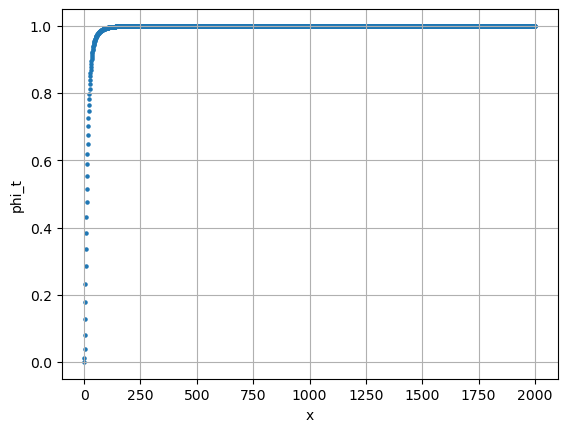

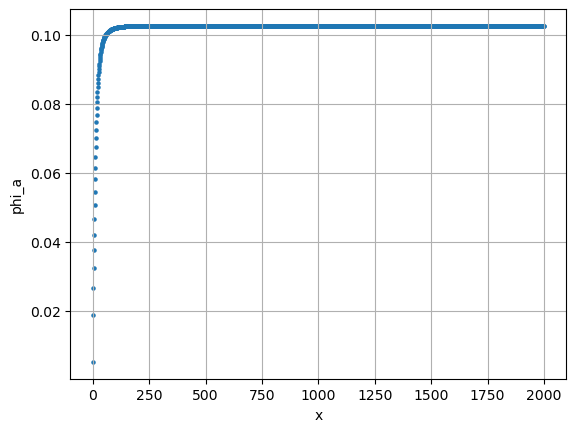

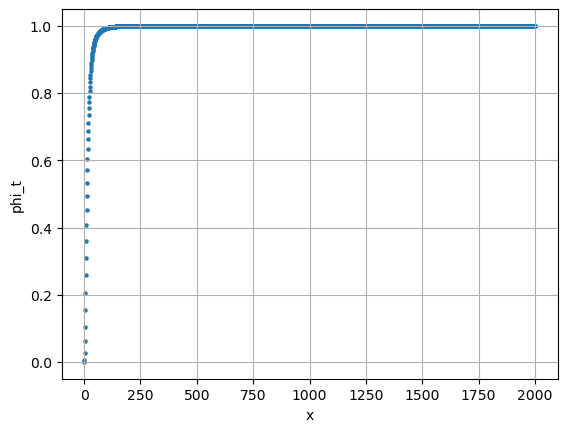

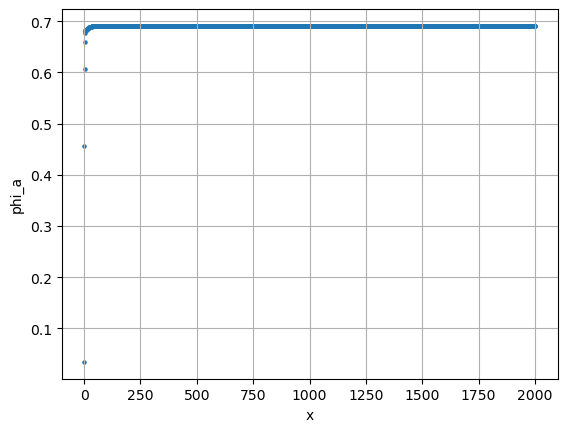

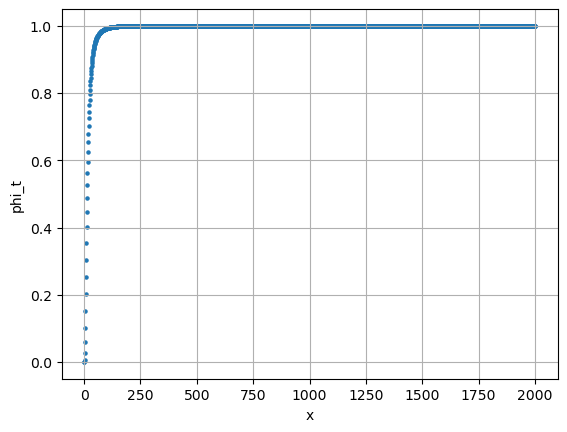

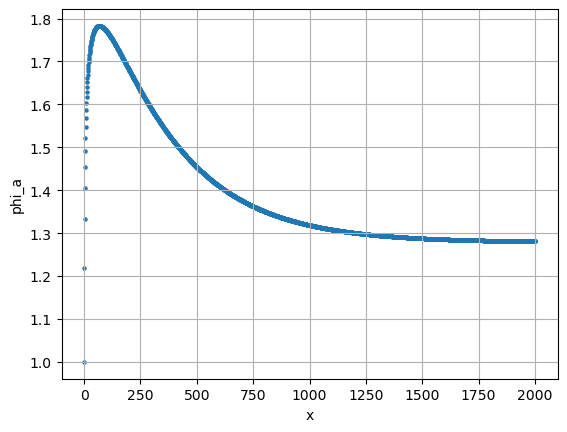

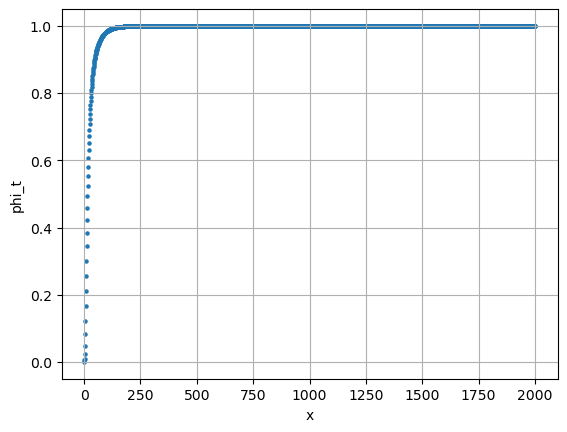

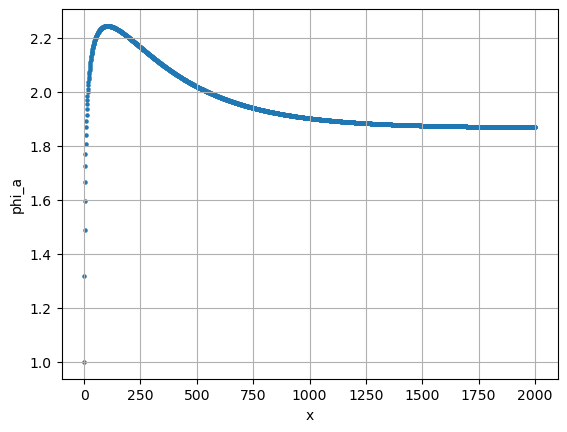

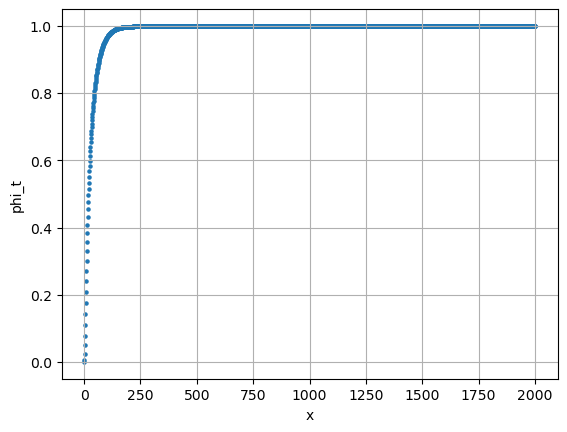

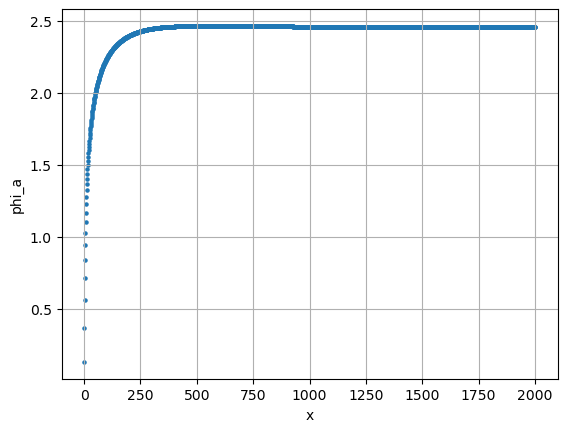

In [14]:
# 単位応答の計算
# 内断熱
for l in range(5):
    r_layer = np.array([
        l * 20 / 1000 / 0.034,
        100 / 1000 / 1.6,
        0.04
    ])
    c_layer = np.array([
        l * 20 / 1000 * 61,
        100 / 1000 * 2000,
        0.0
    ]) * 1000

    print('内断熱　ウレタン', l * 20)
    calc_response_factor(c_layer=c_layer, r_layer=r_layer)

外断熱　ウレタン 0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.776294870475295e-05
       x: [-1.403e-04  6.718e-04 -1.294e-01 -1.312e+00  4.496e-01
           -8.327e-03]
    nfev: 994
   maxcv: 4.440892098500626e-16
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.0741025500206576e-07
       x: [-6.705e-05  2.206e-04 -1.280e-02 -8.674e-02  1.762e-02
           -1.561e-02]
    nfev: 5846
   maxcv: 4.5102810375396984e-17
外断熱　ウレタン 20
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 5.6668425858052815e-05
       x: [-2.961e-03  1.403e-02 -2.030e-01 -9.414e-01  1.178e-01
            6.085e-03  9.411e-03]
    nfev: 10000
   maxcv: -0.0
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 3.8652386912103446e-05
       x: [-2.140e-03  1.014e-02 -1.467e-01 -5.735e-01 -9.796e-03
            1.093e-01 -7.807e-02]
 

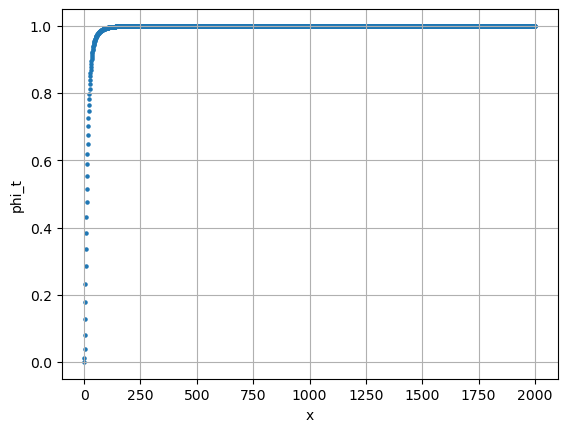

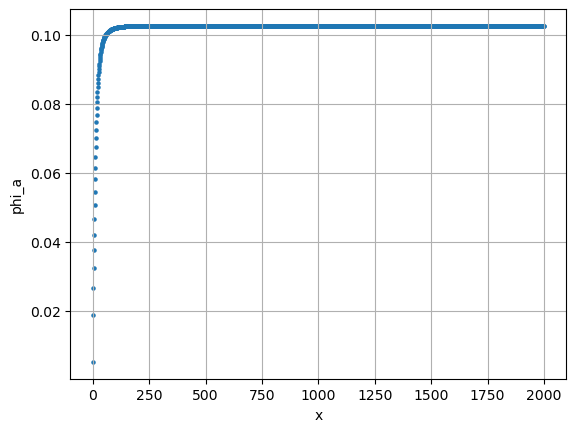

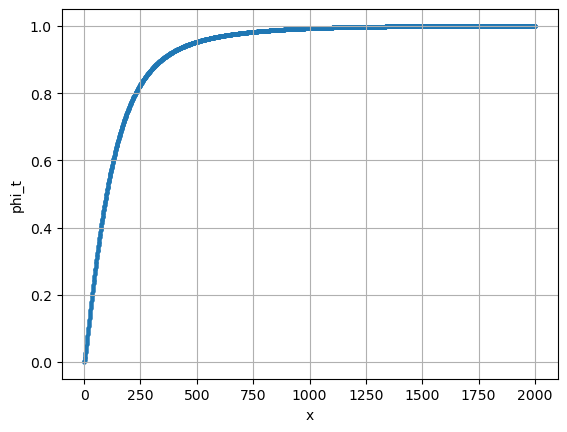

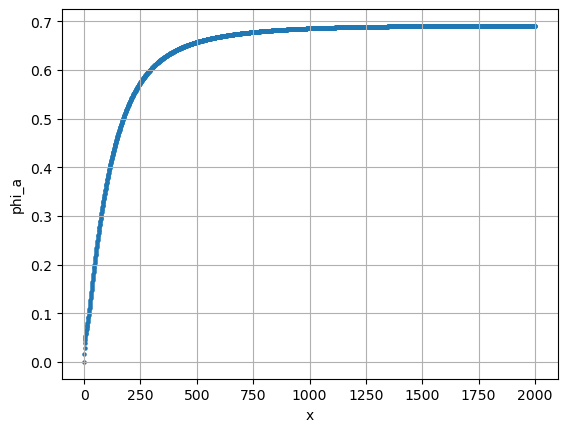

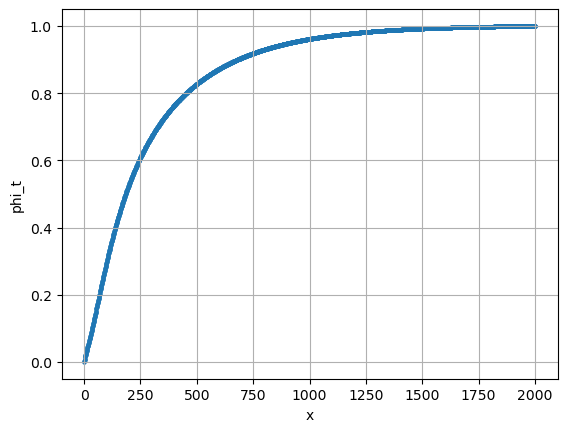

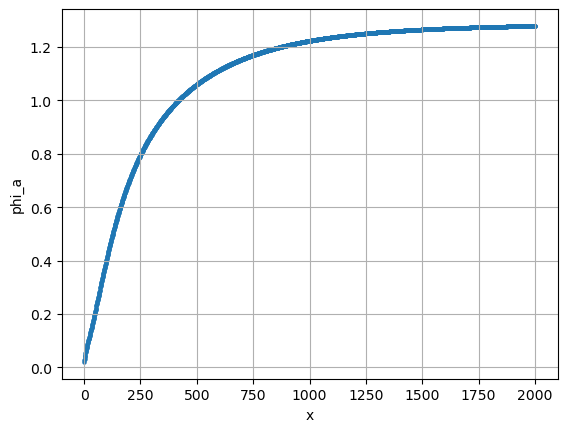

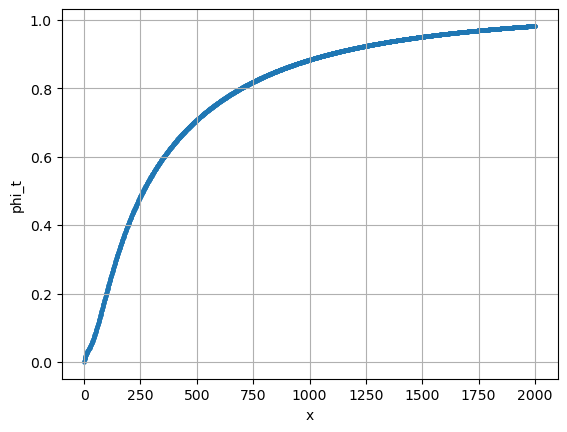

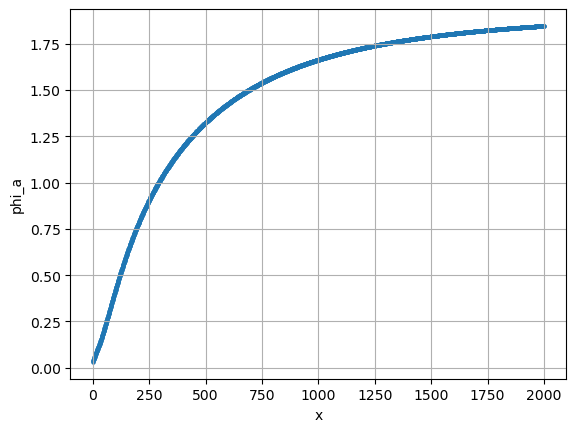

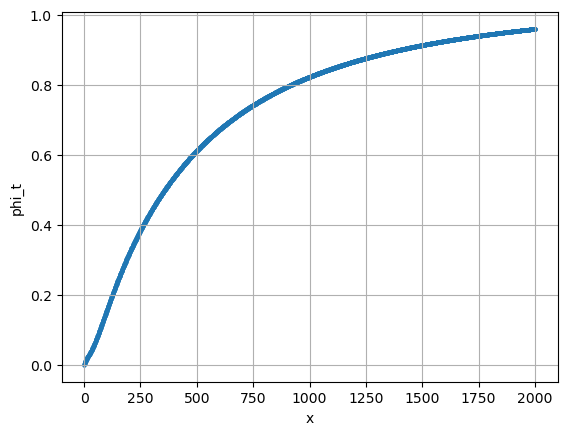

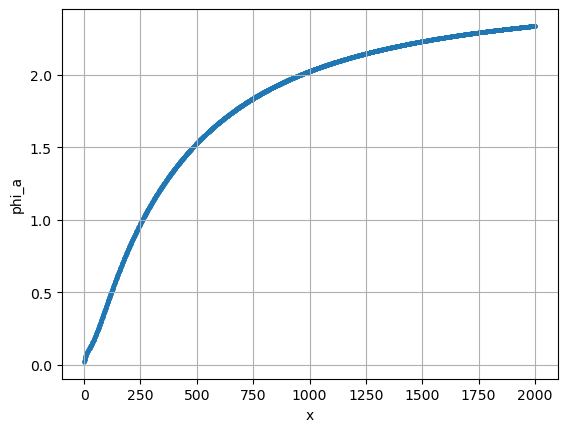

In [15]:
# 外断熱
for l in range(5):
    r_layer = np.array([
        100 / 1000 / 1.6,
        l * 20 / 1000 / 0.034,
        0.04
    ])
    c_layer = np.array([
        100 / 1000 * 2000,
        l * 20 / 1000 * 61,
        0.0
    ]) * 1000

    print('外断熱　ウレタン', l * 20)
    calc_response_factor(c_layer=c_layer, r_layer=r_layer)